# Ensemble model evaluation

In [5]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import json
import logging
logging.basicConfig(level=logging.INFO, handlers=[logging.FileHandler("ensemble.log"), logging.StreamHandler(sys.stdout)])

import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from evaluation import *
from preprocessing import Corpus, BasicPreprocessing, BigramPreprocessor, SpacyPreprocessor, StopWordPreprocessor
from retrieval_algorithms.ensemble_retrieval_algorithm import EnsembleRetrievalAlgorithm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Load keywords to use as test data

In [53]:
with open("../../data/kit_expert_2019_all_keywords.json", "r") as file:
    keywords = json.load(file)

In [54]:
general_keywords = [k for k in keywords if k["level"]<=1]
specific_keywords = [k for k in keywords if k["level"]>=2 and len(k["paper_ids"])>=10]

general_keywords_val = ("general keywords validation", general_keywords[0:int(len(general_keywords)*0.8)])
specific_keywords_val = ("specific keywords validation", specific_keywords[0:int(len(specific_keywords)*0.8)])
general_keywords_test = ("general keywords test", general_keywords[int(len(general_keywords)*0.8):])
specific_keywords_test = ("specific keywords test", specific_keywords[int(len(specific_keywords)*0.8):])

## Load best models

In [3]:
bm25_file_path = "../../data/models/tfidf/bm25_oqe.model"
sent2vec_file_path = "../../data/models/sent2vec/sent2vec_oqe.model"

In [56]:
weight_grid = [0.002, 0.004, 0.006, 0.008, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
search_ensemble_models = [(f"ensemble weight={w}", 
                      EnsembleRetrievalAlgorithm(bm25_file_path, sent2vec_file_path, w),
                      None) for w in weight_grid]

In [ ]:
search_ensemble_results = train_evaluate_models(search_ensemble_models, [general_keywords_val, specific_keywords_val], n_jobs=4)

INFO:root:Start training model ensemble weight=0.002
INFO:root:Start training model ensemble weight=0.006
INFO:root:Start training model ensemble weight=0.01
INFO:root:Start training model ensemble weight=0.04


In [62]:
search_ensemble_results.to_csv("../../data/results/ensemble_results_fine_2.csv")

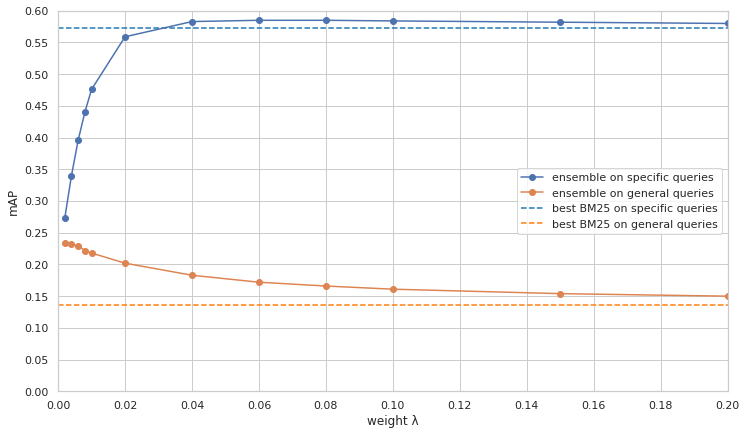

In [67]:
plot_data = search_ensemble_results.xs('mAP', level=1, axis=1).xs('avg', level=1, axis=1)
err_data = search_ensemble_results.xs('mAP', level=1, axis=1).xs('err', level=1, axis=1)
plot_data.index = weight_grid
ax = plot_data.iloc[:,1].plot(label="ensemble on specific queries", figsize=(12,7), style="-o", legend=True, xlim=(0,0.2), ylim=(0,0.6), yticks=np.arange(0,1,0.05), xticks=np.arange(0,0.3,0.02)) #, xticks=[0]+np.linspace(0,1,11), xlim=(0,1), ylim=(0.0,0.3))
ax = plot_data.iloc[:,0].plot(label="ensemble on general queries", figsize=(12,7), style="-o", legend=True)#, xticks=[0]+np.linspace(0,1,11), xlim=(0,1), ylim=(0.0,0.3))
plt.hlines(0.573,0,1, linestyles='dashed', color='tab:blue', label="best BM25 on specific queries")
plt.hlines(0.136,0,1, linestyles='dashed', color='tab:orange', label="best BM25 on general queries")
ax.set_ylabel("mAP");
ax.set_xlabel("weight λ")
ax.legend(loc="center right")
plt.savefig("images/ensemble_model.pdf", transparent=True, bbox_inches="tight")

## Save best ensemble model

In [4]:
ensemble_model = EnsembleRetrievalAlgorithm(bm25_file_path, sent2vec_file_path, 0.04)
ensemble_model.prepare(None)
file_path = "../../data/models/ensemble_model.model"
with open(file_path, "wb") as file:
    pickle.dump(ensemble_model, file)